In [291]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, f1_score, classification_report, plot_confusion_matrix, make_scorer, recall_score, accuracy_score, precision_score, f1_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer, make_column_transformer
from xgboost import XGBClassifier

%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [307]:
X.head()

,account length,international plan,voice mail plan,number vmail messages,total day calls,total day charge,total eve calls,total eve charge,total night calls,total night charge,total intl calls,total intl charge,customer service calls
0,128,no,yes,25,110,45.07,99,16.78,91,11.01,3,2.70,1
1,107,no,yes,26,123,27.47,103,16.62,103,11.45,3,3.70,1
2,137,no,no,0,114,41.38,110,10.30,104,7.32,5,3.29,0
3,84,yes,no,0,71,50.90,88,5.26,89,8.86,7,1.78,2
4,75,yes,no,0,113,28.34,122,12.61,121,8.41,3,2.73,3


In [366]:
y = pd.read_csv('../../src/data/y_dataframe.csv', index_col= 0, squeeze= True)
X = pd.read_csv('../../src/data/X_dataframe.csv', index_col= 0)

In [367]:
# From previous notebook it was discovered the total minutes was directly correlated to the charge so we dropped all the minute columns. 
# Also state didnt seem to play a huge impportance so we took it out to reduce calculation time. 

In [368]:
X.drop(columns=['total day minutes', 'total eve minutes', 'total night minutes', 'total intl minutes', 'state'], axis=1, inplace= True)

<img src='../report/figures/RandomForestClassifier(max_features=0.5, random_state=42)Feature_importance.png' width=600/>

In [369]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size = .2)
X_t, X_val, y_t, y_val = train_test_split(X_train,y_train, random_state=42, test_size = .2)

In [370]:
numerical_features = X_train.select_dtypes(exclude='object').columns
categorical_features = X_train.select_dtypes(include='object').columns

In [371]:
def model_output(model, X_t, X_val, y_t, y_val):
    '''Can be used on final test and train validation''
    input:   model, X_t, X_val, y_t, y_val
    or 
    input:   model, X_train, X_test, y_train, y_test
    '''
    
    model.fit(X_t, y_t)
    y_hat = model.predict(X_val)
    
    print(f'''The Cross Val accuracy is: {cross_val_score(estimator = model, X = X_t,y = y_t, cv = 3, scoring = 'accuracy').mean()}''')
    print(f'The test Accuracy is: {accuracy_score(y_val, y_hat)}')
    print(confusion_matrix(y_val, y_hat))
    print(classification_report(y_val, y_hat))

    return

# Pipeline

In [372]:
preprocess = make_column_transformer(
    (OneHotEncoder(sparse = False, drop ='first'), categorical_features), remainder = 'passthrough')

In [383]:
pipe_forest = Pipeline([
    ('pp', preprocess),
    ('ss', StandardScaler()),
    ('sm', SMOTE(random_state= 42)),
    ('rf', RandomForestClassifier(random_state = 42))])


In [384]:
{'rf__max_depth': 25,
 'rf__max_features': 0.5,
 'rf__min_samples_split': 3,
 'rf__n_estimators': 100}

{'rf__max_depth': 25,
 'rf__max_features': 0.5,
 'rf__min_samples_split': 3,
 'rf__n_estimators': 100}

# Random forest model

Baseline model

In [385]:
model_output(pipe_forest, X_train, X_test, y_train, y_test)

The Cross Val accuracy is: 0.9343612453848674
The test Accuracy is: 0.9370314842578711
[[546  20]
 [ 22  79]]
              precision    recall  f1-score   support

       False       0.96      0.96      0.96       566
        True       0.80      0.78      0.79       101

    accuracy                           0.94       667
   macro avg       0.88      0.87      0.88       667
weighted avg       0.94      0.94      0.94       667



# Random forest with grid models

In [346]:
grid_forest = {
    'rf__min_samples_split': [2, 3, 5], 
    'rf__n_estimators' : [100, 300],
    'rf__max_depth': [5, 15, 25, None],
    'rf__max_features': ['sqrt', 'log2', 10, .5]
}

In [347]:
scorers_forest = {
    'recall_score': make_scorer(recall_score),
    'precision_score': make_scorer(precision_score),
    'f1': make_scorer(f1_score)
    }

# Maximizing f1

In [351]:
grid_search_f1 = GridSearchCV(pipe_forest, grid_forest, scoring=scorers_forest, refit='f1',
                           cv=3, return_train_score=True, n_jobs=-1)

model_output(grid_search_f1, X_t, X_val, y_t, y_val)

The Cross Val accuracy is: 0.9301195829453985
The test Accuracy is: 0.9363295880149812
[[437  19]
 [ 15  63]]
              precision    recall  f1-score   support

       False       0.97      0.96      0.96       456
        True       0.77      0.81      0.79        78

    accuracy                           0.94       534
   macro avg       0.87      0.88      0.88       534
weighted avg       0.94      0.94      0.94       534



In [352]:
grid_search_f1.best_params_

{'rf__max_depth': 25,
 'rf__max_features': 0.5,
 'rf__min_samples_split': 3,
 'rf__n_estimators': 100}

In [353]:
grid_search_recall = GridSearchCV(pipe_forest, grid_forest, scoring=scorers_forest, refit='recall_score',
                           cv=3, return_train_score=True, n_jobs=-1)

model_output(grid_search_recall, X_t, X_val, y_t, y_val)

The Cross Val accuracy is: 0.9015167422726703
The test Accuracy is: 0.9157303370786517
[[422  34]
 [ 11  67]]
              precision    recall  f1-score   support

       False       0.97      0.93      0.95       456
        True       0.66      0.86      0.75        78

    accuracy                           0.92       534
   macro avg       0.82      0.89      0.85       534
weighted avg       0.93      0.92      0.92       534



In [355]:
grid_search_recall.best_params_

{'rf__max_depth': 5,
 'rf__max_features': 0.5,
 'rf__min_samples_split': 3,
 'rf__n_estimators': 300}

In [356]:
grid_search_precision = GridSearchCV(pipe_forest, grid_forest, scoring=scorers_forest, refit='precision_score',
                           cv=3, return_train_score=True, n_jobs=-1)

model_output(grid_search_precision, X_t, X_val, y_t, y_val)

The Cross Val accuracy is: 0.9301189226309569
The test Accuracy is: 0.9363295880149812
[[437  19]
 [ 15  63]]
              precision    recall  f1-score   support

       False       0.97      0.96      0.96       456
        True       0.77      0.81      0.79        78

    accuracy                           0.94       534
   macro avg       0.87      0.88      0.88       534
weighted avg       0.94      0.94      0.94       534



In [357]:
grid_search_precision.best_params_

{'rf__max_depth': 25,
 'rf__max_features': 0.5,
 'rf__min_samples_split': 3,
 'rf__n_estimators': 100}

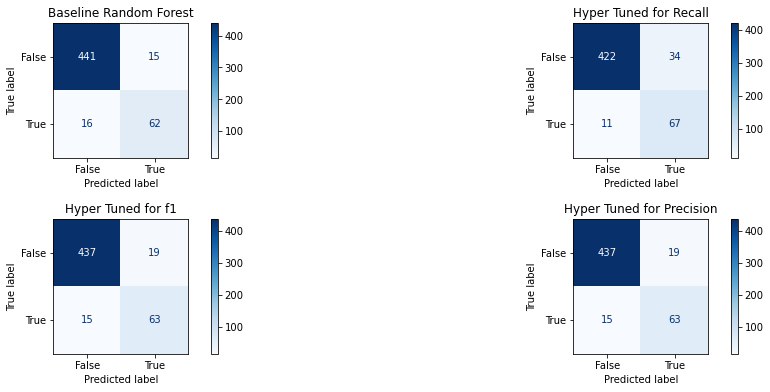

In [358]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6))
fig.tight_layout(pad=4.0)

axes[0,0].set_title("Baseline Random Forest")
axes[1,0].set_title("Hyper Tuned for f1")
axes[0,1].set_title("Hyper Tuned for Recall")
axes[1,1].set_title("Hyper Tuned for Precision")

plot_confusion_matrix(pipe_forest, X_val, y_val, ax=axes[0,0], cmap="Blues")
plot_confusion_matrix(grid_search_f1, X_val, y_val, ax=axes[1,0], cmap="Blues")
plot_confusion_matrix(grid_search_recall, X_val, y_val, ax=axes[0,1], cmap="Blues")
plot_confusion_matrix(grid_search_precision, X_val, y_val, ax=axes[1,1], cmap="Blues")

Hyper Tuned for Precision seems to give the best overall results. Ideally we want our False negative as low as possible like the one hypertuned for recall.

# XGBoost classifier

In [293]:
pipe_XG = Pipeline([
    ('pp', preprocess),
    ('ss', StandardScaler()),
    ('sm', SMOTE(random_state= 42)),
    ('xg', XGBClassifier(random_state = 42))])


In [296]:
model_output(pipe_XG, X_t, X_val, y_t, y_val)

The Cross Val accuracy is: 0.9413746426048085
The test Accuracy is: 0.9456928838951311
[[443  13]
 [ 16  62]]
              precision    recall  f1-score   support

       False       0.97      0.97      0.97       456
        True       0.83      0.79      0.81        78

    accuracy                           0.95       534
   macro avg       0.90      0.88      0.89       534
weighted avg       0.94      0.95      0.95       534



In [ ]:
grid_xg

In [ ]:
grid_search_xg = GridSearchCV(pipe_XG, grid_forest, scoring=scorers_forest, refit='precision_score',
                           cv=3, return_train_score=True, n_jobs=-1)